### 手写数字识别

在本节我们将使用`PyTorch`构建一个简单的卷积神经网络用于手写数字识别，以帮助读者大致理解`PyTorch`如何在实际项目中运用。

首先根据前两节的指南安装好`PyTorch`，然后引入相关库。

In [65]:
import torch 
import torchvision
from torch.utils.data import DataLoader

然后，我们将定义实验中将要使用的超参数。在这里`epoch`代表我们将循环整个训练数据集的次数，而`learning rate`和`momentum`是稍后优化器将要使用的超参数。

In [66]:
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
n_epochs = 3
random_seed = 1
log_interval = 10
torch.manual_seed(random_seed)

然后我们加载`MNIST`数据集，并使用`batch size=64`进行训练，`batch size=1000`进行测试。下面的`Normalize()`转换使用的值`0.1307`和`0.3081`是`MNIST`数据集的全局平均值和标准差，这里将它们作为定值。而`torchvision`提供了很多方便的转换，比如裁剪，标准化，在后面我们也会进行学习。

In [67]:
train_loader = DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size = batch_size_train, shuffle=True)

test_loader = DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True,
                                    transform=torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize(
                                            (0.1307,), (0.3081,))
                                    ])),
    batch_size = batch_size_test, shuffle=True) 

除了数据集和批处理大小之外,PyTorch的Dataloader还包含更多的选项。比如`number_workers`和`pin_memory`，但我们在这里暂时省略他们。

我们在下面打印出一些测试数据来观察它们的组成。

In [68]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets) # example targets是图片对应的数字标签
print(example_data.shape) # 一批测试数据是一个4维张量

tensor([3, 9, 4, 9, 9, 0, 8, 3, 1, 2, 3, 9, 1, 3, 6, 6, 4, 4, 9, 7, 3, 7, 6, 3,
        4, 8, 4, 6, 8, 6, 1, 1, 1, 1, 0, 0, 1, 8, 4, 0, 1, 2, 7, 9, 3, 2, 3, 8,
        3, 2, 0, 4, 6, 6, 5, 5, 3, 0, 3, 7, 2, 4, 1, 6, 7, 5, 4, 1, 0, 8, 5, 9,
        0, 9, 6, 1, 8, 0, 9, 3, 5, 7, 8, 5, 6, 4, 2, 2, 2, 1, 8, 4, 4, 2, 1, 5,
        9, 3, 7, 0, 4, 1, 7, 2, 2, 6, 5, 1, 2, 6, 1, 3, 1, 2, 7, 4, 1, 3, 2, 9,
        3, 7, 2, 7, 4, 7, 0, 0, 9, 0, 9, 5, 1, 6, 9, 8, 1, 4, 6, 7, 5, 5, 6, 4,
        5, 4, 0, 7, 4, 1, 3, 8, 2, 6, 2, 2, 8, 4, 1, 9, 6, 7, 5, 0, 7, 4, 6, 2,
        6, 8, 7, 9, 8, 0, 7, 4, 2, 4, 9, 0, 4, 6, 5, 6, 6, 4, 4, 8, 3, 8, 0, 9,
        5, 6, 3, 3, 8, 4, 4, 6, 7, 8, 5, 3, 4, 3, 3, 3, 3, 1, 8, 8, 9, 1, 0, 1,
        4, 1, 0, 2, 0, 6, 5, 1, 5, 8, 8, 1, 3, 9, 4, 5, 9, 2, 5, 6, 5, 8, 2, 7,
        4, 1, 6, 8, 7, 9, 3, 3, 4, 4, 5, 4, 9, 8, 2, 9, 1, 6, 7, 1, 0, 5, 1, 9,
        2, 1, 5, 2, 7, 9, 0, 0, 6, 0, 8, 7, 2, 6, 1, 7, 6, 1, 2, 1, 6, 3, 1, 4,
        1, 7, 5, 9, 3, 8, 6, 3, 8, 7, 4,

上面张量的形状意味着`1000`个 `28×28` 像素的灰度图像(无RGB图像)，下面我们使用`matplotlib`绘制出一些来观察。

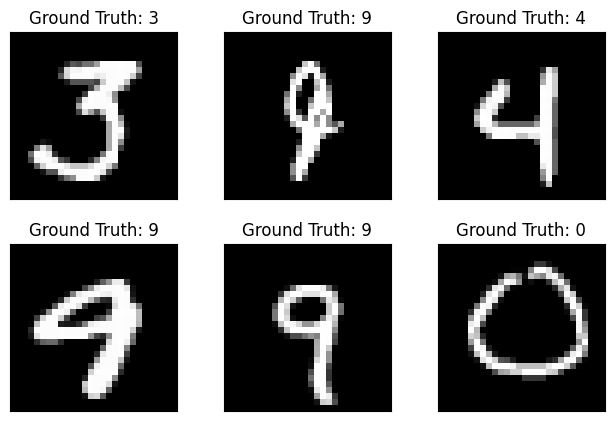

In [69]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

现在让我们构建自己的网络。

In [70]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

构建自己的优化器和初始网络。

In [71]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

构建完成网络后，我们首先将网络调整至训练模式，然后建立我们的训练循环。

首先，我们使用`optimizer.zero_grad()`手动将梯度设置为`0`。随后，我们利用网络的输出，计算输出与真实标签之间的负对数概率损失。现在，收集一组新的梯度，并使用`optimizer.step()`将每其传播回每个网络参数。我们还将打印一些输出以跟踪训练进度，

In [72]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

正式开始训练之前，我们将运行一次测试循环，看看仅使用随机初始化的网络参数可以获得多大的损失。

In [73]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [74]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(model.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

神经网络模块以及优化器能够使用`.state_dict()`保存和加载它们的内部状态。这样如果需要，我们就可以继续从以前保存的状态`dict`中进行训练-只需要调用`.load_state_dict(state_dict)`。

In [75]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()



Test set: Average loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140658
Train Epoch: 1 [1216

经过`3`个阶段的训练，在测试集上的分类准确率已经能够达到`97%`。接下来，我们来画一下训练曲线。

4
4


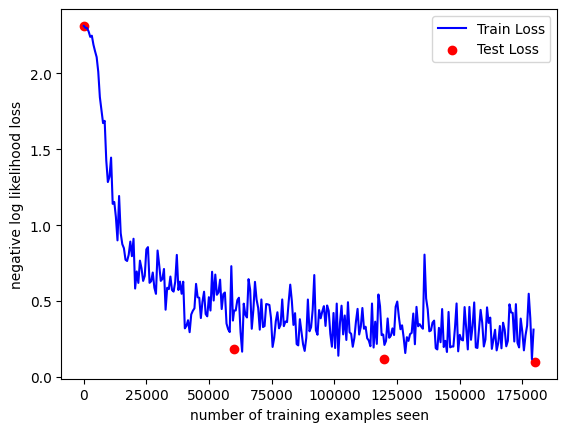

In [76]:
import matplotlib.pyplot as plt
fig = plt.figure()
print(len(test_losses))
print(len(test_counter))
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')

plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

从训练曲线来看，我们可以在训练几个轮次直到收敛。在此之前，我们看一下几个使用训练得到的模型预测图片的例子。

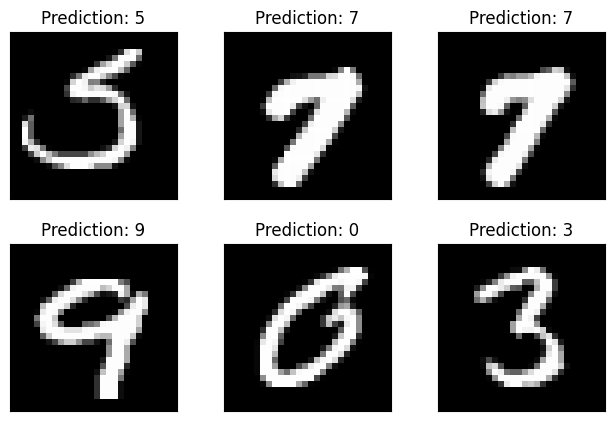

In [77]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = model(example_data)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()

我们训练得到的模型对于这些例子的预测都是正确的。

接下来，我们可以从第一次训练运行保存的`state_dicts`中继续训练，我们将初始化新的网络和优化器。

In [78]:
continued_model = Net()
continued_optimizer = optim.SGD(continued_model.parameters(), lr=learning_rate,
                                  momentum=momentum)

使用`.load_state_dict()`，我们现在可以加载网络的内部状态，并在最后一次保存时优化它们。

In [82]:
network_state_dict = torch.load('./model.pth',weights_only=True)
continued_model.load_state_dict(network_state_dict)
optimizer_state_dict = torch.load('./optimizer.pth',weights_only=True)
continued_optimizer.load_state_dict(optimizer_state_dict)

同样，运行一个训练应该立即恢复我们之前的训练。为了检查这一点，我们只需要使用与前面相同的列表来跟踪损失值。

In [80]:
for i in range(4,9):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.363699
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.111991
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.247361
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.148913
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.301657
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.259088
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.221154
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.246145
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.520658
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.159107
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.198615
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.225745
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.397284
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.121305
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.203201
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.270978
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.256362
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.217322
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.326653
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.284240
Train Epoch: 4 [12800/60000 (

可以看到，分类准确率有了进一步的提高，我们利用图像来进一步检查训练进度。

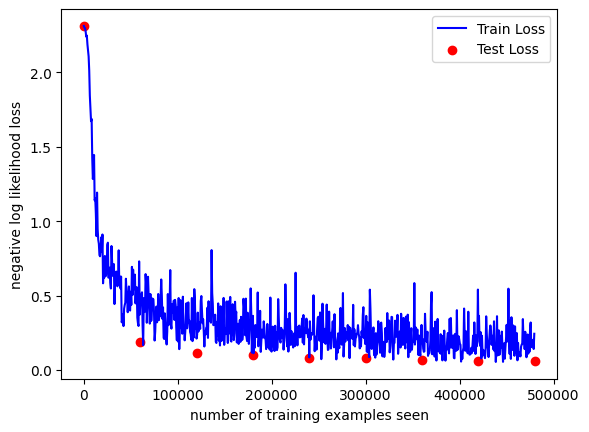

In [81]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

新的学习曲线看起来比之前的图像平滑，也证明了从权重内部状态继续按照预期进行了训练。

在这一节，我们使用`PyTorch`和`torchvision`构建了一个手写数字识别的项目，并利用它对`MNIST`数据集中的手写数字进行了分类，希望大家能对`PyTorch`有一个初步的了解。